In [1]:
# Install necessary libraries
print("Installing required libraries...")
!pip install timm opencv-python pywavelets scikit-learn matplotlib seaborn -q

# Mount Google Drive
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

print("Setup Complete!")


Installing required libraries...
Mounting Google Drive...
Mounted at /content/drive
Setup Complete!


Cell 2: Define Paths and Hyperparameters
Customize these paths to match your dataset location and set training parameters.

Action: UPDATE DRIVE_PATH, AI_GEN_IMAGES_PATH, REAL_ART_IMAGES_PATH with your exact paths.

Action: Review and adjust IMAGE_SIZE, BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE if needed.

Action: Run this cell.

In [2]:
import os

# --- Dataset Paths ---
# IMPORTANT: Update this to your base project directory in Google Drive
DRIVE_PATH = "/content/drive/MyDrive/AI gen Images/archive"

# Paths to your AI-generated and Real image directories
AI_GEN_IMAGES_PATH = os.path.join(DRIVE_PATH, "AiArtData/AiArtData")
REAL_ART_IMAGES_PATH = os.path.join(DRIVE_PATH, "RealArt/RealArt")

# --- Model & Training Hyperparameters ---
IMAGE_SIZE = 224      # Standard size for many pre-trained CNNs
BATCH_SIZE = 32       # Adjust based on GPU memory. Lower if you get OOM errors.
NUM_EPOCHS = 15       # Number of training epochs. Can increase for better performance.
LEARNING_RATE = 1e-4  # Learning rate for the optimizer
NUM_WORKERS = 2       # Number of subprocesses to use for data loading. 0 means main process.

# --- Model Architecture ---
# Base feature extractor for each forensic stream.
# 'efficientnet_b0' is a good balance of performance and speed.
# Can try 'resnet18', 'mobilenetv2_100', 'efficientnet_b4' (more complex)
BACKBONE_MODEL = 'efficientnet_b0'

# --- Verification ---
print(f"Checking AI-generated images path: {AI_GEN_IMAGES_PATH} (exists: {os.path.exists(AI_GEN_IMAGES_PATH)})")
print(f"Checking Real art images path: {REAL_ART_IMAGES_PATH} (exists: {os.path.exists(REAL_ART_IMAGES_PATH)})")

if not os.path.exists(AI_GEN_IMAGES_PATH) or not os.path.exists(REAL_ART_IMAGES_PATH):
    raise FileNotFoundError("One or both dataset paths do not exist. Please check DRIVE_PATH and sub-paths.")

print("\nConfiguration Loaded Successfully!")


Checking AI-generated images path: /content/drive/MyDrive/AI gen Images/archive/AiArtData/AiArtData (exists: True)
Checking Real art images path: /content/drive/MyDrive/AI gen Images/archive/RealArt/RealArt (exists: True)

Configuration Loaded Successfully!


Cell 3: Implement Forensic Image Preprocessing Functions
These functions convert an RGB image into its FFT, Wavelet, and ELA representations. They will form the "multi-channel" inputs for our complex model.

Action: Run this cell. No output expected other than function definitions.

In [3]:
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import cv2
import pywt
import torch
from torchvision import transforms
import io  # <-- ADDED THIS IMPORT

def to_tensor(img):
    """Converts a PIL Image or NumPy array to a PyTorch Tensor."""
    return transforms.ToTensor()(img)

def normalize_tensor(tensor):
    """Normalizes a PyTorch Tensor to [0, 1] range if not already there."""
    # Ensure tensor is float
    tensor = tensor.float()
    # Normalize per channel if min/max not 0/1, handle potential single-channel
    for i in range(tensor.shape[0]):
        min_val = tensor[i].min()
        max_val = tensor[i].max()
        if max_val - min_val > 1e-6: # Avoid division by zero for flat channels
            tensor[i] = (tensor[i] - min_val) / (max_val - min_val)
    return tensor

def rgb_to_grayscale_pil(img_pil):
    """Converts a PIL RGB image to a grayscale PIL image."""
    return img_pil.convert('L')

def apply_fft(img_pil):
    """
    Applies Fast Fourier Transform (FFT) to a grayscale image.
    Returns a normalized magnitude spectrum as a PIL Image.
    """
    img_gray = np.array(rgb_to_grayscale_pil(img_pil))
    f_transform = np.fft.fft2(img_gray)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_transform_shifted) + 1e-6) # Add epsilon to avoid log(0)

    # Normalize to [0, 255] range for PIL conversion
    magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)
    return Image.fromarray(magnitude_spectrum.astype(np.uint8))

def apply_wavelet_transform(img_pil, wavelet='db1', level=1):
    """
    Applies Discrete Wavelet Transform (DWT) to a grayscale image.
    Returns the horizontal detail coefficients (cH) as a normalized PIL Image.
    """
    img_gray = np.array(rgb_to_grayscale_pil(img_pil))

    # Perform DWT decomposition
    coeffs = pywt.dwt2(img_gray, wavelet)
    cA, (cH, cV, cD) = coeffs

    # We often find high-frequency components (like cH, cV, cD) useful for forensic analysis
    # Let's use cH (Horizontal detail) as an example
    cH_normalized = cv2.normalize(np.abs(cH), None, 0, 255, cv2.NORM_MINMAX)
    return Image.fromarray(cH_normalized.astype(np.uint8))

def apply_ela(img_pil, quality=90, scale=15):
    """
    Performs Error Level Analysis (ELA) on an RGB image.
    Returns the enhanced ELA difference image as a PIL Image.
    """
    # Save and re-load as JPEG to simulate compression
    buffer = io.BytesIO()
    img_pil.save(buffer, 'JPEG', quality=quality)
    resaved_img = Image.open(buffer).convert('RGB')

    # Calculate difference
    ela_diff = ImageChops.difference(img_pil, resaved_img)

    # Enhance for visibility
    enhancer = ImageEnhance.Brightness(ela_diff)
    ela_enhanced = enhancer.enhance(scale)
    return ela_enhanced

print("Forensic preprocessing functions defined.")



Forensic preprocessing functions defined.


Cell 4: Visual Proof of Forensic Inputs (Optional but Recommended)
This cell demonstrates what the FFT, Wavelet, and ELA inputs actually look like for a sample image. This is your "visual proof" that these techniques are generating distinct views.

Action: Run this cell.

Output: A figure showing an original image and its FFT, Wavelet, and ELA transformations.

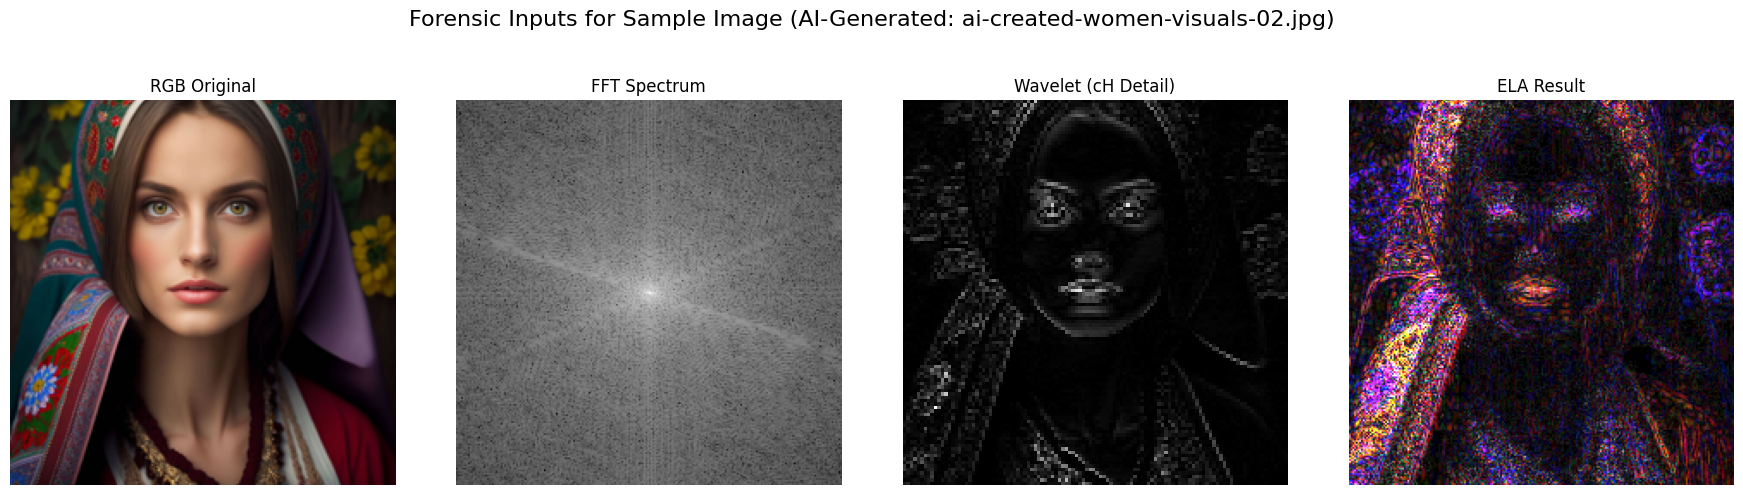

Visual proof of forensic inputs generated. Observe the distinct patterns.


In [4]:
import random
import glob
import matplotlib.pyplot as plt

# Get a sample image path (ensure it exists)
sample_ai_path = glob.glob(os.path.join(AI_GEN_IMAGES_PATH, '*.*'))
sample_real_path = glob.glob(os.path.join(REAL_ART_IMAGES_PATH, '*.*'))

if not sample_ai_path:
    raise ValueError("No AI-generated images found in the specified path.")
if not sample_real_path:
    raise ValueError("No Real images found in the specified path.")

sample_image_path = random.choice(sample_ai_path) # You can change to sample_real_path to see a real image example
sample_image_pil = Image.open(sample_image_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))

# Apply transformations
fft_img = apply_fft(sample_image_pil)
wavelet_img = apply_wavelet_transform(sample_image_pil)
ela_img = apply_ela(sample_image_pil)

# Display
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle(f'Forensic Inputs for Sample Image (AI-Generated: {os.path.basename(sample_image_path)})', fontsize=16)

axes[0].imshow(sample_image_pil)
axes[0].set_title('RGB Original')
axes[0].axis('off')

axes[1].imshow(fft_img, cmap='gray')
axes[1].set_title('FFT Spectrum')
axes[1].axis('off')

axes[2].imshow(wavelet_img, cmap='gray')
axes[2].set_title('Wavelet (cH Detail)')
axes[2].axis('off')

axes[3].imshow(ela_img, cmap='gray')
axes[3].set_title('ELA Result')
axes[3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
print("Visual proof of forensic inputs generated. Observe the distinct patterns.")


Cell 5: Create a Custom Dataset for Multiple Inputs
This dataset class will load an image and generate its RGB, FFT, Wavelet, and ELA representations on the fly.

Action: Run this cell.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import random # <-- Included for random.shuffle

class MultiForensicDataset(Dataset):
    def __init__(self, ai_path, real_path, img_size=224):
        self.ai_images = glob.glob(os.path.join(ai_path, '*.*'))
        self.real_images = glob.glob(os.path.join(real_path, '*.*'))
        self.all_images = [(img, 1) for img in self.ai_images] + [(img, 0) for img in self.real_images]

        # Shuffle the combined list to ensure randomness during training
        random.shuffle(self.all_images)

        self.img_size = img_size

        # RGB Image Transformations
        self.rgb_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Grayscale (for FFT/Wavelet/ELA) Image Transformations
        # Note: ToTensor will convert (H, W) to (1, H, W).
        # Normalization will be applied manually in __getitem__ to each channel after conversion.
        self.grayscale_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(), # Converts to (1, H, W) and scales to [0,1]
        ])

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]
        img_pil = Image.open(img_path).convert('RGB')

        # Apply transformations for each stream
        rgb_tensor = self.rgb_transform(img_pil)

        # Grayscale for forensic transforms (ensures consistency)
        img_pil_gray_resized = img_pil.resize((self.img_size, self.img_size))

        fft_img = apply_fft(img_pil_gray_resized)
        wavelet_img = apply_wavelet_transform(img_pil_gray_resized)
        ela_img = apply_ela(img_pil_gray_resized)

        # --- FIX IS HERE ---
        # Convert ELA image to grayscale to match the other forensic streams
        ela_img_gray = ela_img.convert('L')
        # --- END FIX ---

        # Convert forensic outputs to tensors and normalize manually
        # They will be (1, H, W) after ToTensor, we stack them later
        fft_tensor = normalize_tensor(self.grayscale_transform(fft_img))
        wavelet_tensor = normalize_tensor(self.grayscale_transform(wavelet_img))

        # --- FIX IS HERE ---
        # Use the new grayscale ELA image
        ela_tensor = normalize_tensor(self.grayscale_transform(ela_img_gray))
        # --- END FIX ---

        # Return a dictionary of tensors and the label
        return {
            'rgb': rgb_tensor,
            'fft': fft_tensor,
            'wavelet': wavelet_tensor,
            'ela': ela_tensor,
            'label': torch.tensor(label, dtype=torch.float32)
        }

print("MultiForensicDataset class defined.")



MultiForensicDataset class defined.


Cell 6: Split Dataset and Create DataLoaders
This cell prepares your data for training and validation.

Action: Run this cell.

Output: Information about the dataset split.

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import random

# Create the full dataset
full_dataset = MultiForensicDataset(AI_GEN_IMAGES_PATH, REAL_ART_IMAGES_PATH, IMAGE_SIZE)

# Perform train-validation split
train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2, # 20% for validation
    random_state=42,
    stratify=[label for _, label in full_dataset.all_images] # Stratify to maintain class balance
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print("\nDataLoaders created successfully!")


Total images: 972
Training images: 777
Validation images: 195

DataLoaders created successfully!


Cell 7: Define the "HybridForensicsNet" (Your Complex Model)
This is the core of your "complex model" request. It features four distinct pre-trained backbones (stems) for each input type (RGB, FFT, Wavelet, ELA), and then fuses their features before a final classification.

Action: Run this cell.

In [7]:
import torch.nn as nn
import timm

class HybridForensicsNet(nn.Module):
    def __init__(self, backbone_model_name=BACKBONE_MODEL, num_classes=1, pretrained=True):
        super(HybridForensicsNet, self).__init__()

        # --- RGB Stream ---
        # A standard pre-trained backbone for the original RGB image
        self.rgb_stream = timm.create_model(backbone_model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        # Get the number of features produced by the RGB backbone before the head
        self.rgb_feature_dim = self.rgb_stream.num_features

        # --- Forensic Streams (FFT, Wavelet, ELA) ---
        # For each forensic input, we use a separate backbone.
        # These are usually single-channel (grayscale), so we adjust `in_chans`.
        # num_classes=0 means it will return features, not a classification.
        # global_pool='avg' ensures a fixed-size feature vector.

        self.fft_stream = timm.create_model(backbone_model_name, pretrained=pretrained, num_classes=0, in_chans=1, global_pool='avg')
        self.wavelet_stream = timm.create_model(backbone_model_name, pretrained=pretrained, num_classes=0, in_chans=1, global_pool='avg')
        self.ela_stream = timm.create_model(backbone_model_name, pretrained=pretrained, num_classes=0, in_chans=1, global_pool='avg')

        # All forensic streams will likely output the same feature dim as RGB if the backbone is the same
        self.forensic_feature_dim = self.fft_stream.num_features # Assuming same dim for all forensic streams

        # --- Fusion Layer ---
        # Concatenate features from all four streams
        total_fused_features = self.rgb_feature_dim + (3 * self.forensic_feature_dim)

        # Simple fully connected layers for fusion and classification
        self.classifier = nn.Sequential(
            nn.Linear(total_fused_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes) # Final output for binary classification
        )

    def forward(self, inputs):
        # Extract features from each stream
        rgb_features = self.rgb_stream(inputs['rgb'])
        fft_features = self.fft_stream(inputs['fft'])
        wavelet_features = self.wavelet_stream(inputs['wavelet'])
        ela_features = self.ela_stream(inputs['ela'])

        # Concatenate features from all streams
        fused_features = torch.cat((rgb_features, fft_features, wavelet_features, ela_features), dim=1)

        # Pass through the classifier head
        output = self.classifier(fused_features)
        return output

print(f"HybridForensicsNet model architecture defined using {BACKBONE_MODEL} backbones.")
print(f"Total streams: RGB, FFT, Wavelet, ELA. Features will be fused from all four.")


HybridForensicsNet model architecture defined using efficientnet_b0 backbones.
Total streams: RGB, FFT, Wavelet, ELA. Features will be fused from all four.


Cell 8: Training and Evaluation Functions
Standard functions to handle the training loop, validation, and performance metrics.

Action: Run this cell.

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # Move all inputs and label to the device
        rgb_inputs = data['rgb'].to(device)
        fft_inputs = data['fft'].to(device)
        wavelet_inputs = data['wavelet'].to(device)
        ela_inputs = data['ela'].to(device)
        labels = data['label'].to(device).unsqueeze(1) # Ensure labels are (batch_size, 1)

        optimizer.zero_grad()

        outputs = model({'rgb': rgb_inputs, 'fft': fft_inputs, 'wavelet': wavelet_inputs, 'ela': ela_inputs})
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            rgb_inputs = data['rgb'].to(device)
            fft_inputs = data['fft'].to(device)
            wavelet_inputs = data['wavelet'].to(device)
            ela_inputs = data['ela'].to(device)
            labels = data['label'].to(device).unsqueeze(1)

            outputs = model({'rgb': rgb_inputs, 'fft': fft_inputs, 'wavelet': wavelet_inputs, 'ela': ela_inputs})
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs).round() # Convert logits to probabilities, then to binary (0 or 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # ROC AUC requires probabilities, not binary predictions
    # Make sure to pass original probabilities before rounding for AUC
    all_probs = []
    with torch.no_grad(): # Recalculate probabilities for AUC
        for i, data in enumerate(dataloader):
            rgb_inputs = data['rgb'].to(device)
            fft_inputs = data['fft'].to(device)
            wavelet_inputs = data['wavelet'].to(device)
            ela_inputs = data['ela'].to(device)
            labels = data['label'].to(device).unsqueeze(1)
            outputs = model({'rgb': rgb_inputs, 'fft': fft_inputs, 'wavelet': wavelet_inputs, 'ela': ela_inputs})
            all_probs.extend(torch.sigmoid(outputs).cpu().numpy())
    auc = roc_auc_score(all_labels, all_probs)

    return val_loss, accuracy, precision, recall, f1, auc, np.array(all_labels), np.array(all_preds)

print("Training and evaluation functions defined.")


Training and evaluation functions defined.


Cell 9: Initialize and Train the HybridForensicsNet
This is where the training magic happens!

Action: Run this cell.

Output: Training progress per epoch, loss, and validation metrics. This will take time depending on your GPU and dataset size.

In [9]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

model = HybridForensicsNet(backbone_model_name=BACKBONE_MODEL, num_classes=1, pretrained=True)
model.to(device)

criterion = nn.BCEWithLogitsLoss() # Good for binary classification
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Lists to store training history
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

print("\nStarting training for HybridForensicsNet...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = validate_model(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"Val Prec: {val_prec:.4f} | "
          f"Val Rec: {val_rec:.4f} | "
          f"Val F1: {val_f1:.4f} | "
          f"Val AUC: {val_auc:.4f} | "
          f"Time: {(epoch_end_time - epoch_start_time):.1f}s")

end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time):.1f} seconds.")


Training on device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Starting training for HybridForensicsNet...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train Loss: 0.6815 | Val Loss: 3.7466 | Val Acc: 0.5538 | Val Prec: 0.6438 | Val Rec: 0.4352 | Val F1: 0.5193 | Val AUC: 0.6085 | Time: 191.7s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/15 | Train Loss: 0.4497 | Val Loss: 2.0899 | Val Acc: 0.5077 | Val Prec: 0.8750 | Val Rec: 0.1296 | Val F1: 0.2258 | Val AUC: 0.8484 | Time: 69.7s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/15 | Train Loss: 0.3069 | Val Loss: 0.7108 | Val Acc: 0.5333 | Val Prec: 1.0000 | Val Rec: 0.1574 | Val F1: 0.2720 | Val AUC: 0.8887 | Time: 68.2s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/15 | Train Loss: 0.2264 | Val Loss: 0.4782 | Val Acc: 0.7487 | Val Prec: 0.9155 | Val Rec: 0.6019 | Val F1: 0.7263 | Val AUC: 0.8811 | Time: 66.8s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/15 | Train Loss: 0.1608 | Val Loss: 0.4231 | Val Acc: 0.7949 | Val Prec: 0.9048 | Val Rec: 0.7037 | Val F1: 0.7917 | Val AUC: 0.9103 | Time: 67.0s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/15 | Train Loss: 0.1378 | Val Loss: 0.4286 | Val Acc: 0.7846 | Val Prec: 0.9024 | Val Rec: 0.6852 | Val F1: 0.7789 | Val AUC: 0.9056 | Time: 67.8s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/15 | Train Loss: 0.1092 | Val Loss: 0.4271 | Val Acc: 0.8000 | Val Prec: 0.9367 | Val Rec: 0.6852 | Val F1: 0.7914 | Val AUC: 0.9117 | Time: 68.3s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/15 | Train Loss: 0.0919 | Val Loss: 0.3930 | Val Acc: 0.7949 | Val Prec: 0.8778 | Val Rec: 0.7315 | Val F1: 0.7980 | Val AUC: 0.9086 | Time: 66.3s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/15 | Train Loss: 0.0817 | Val Loss: 0.4067 | Val Acc: 0.8000 | Val Prec: 0.9259 | Val Rec: 0.6944 | Val F1: 0.7937 | Val AUC: 0.9149 | Time: 66.7s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/15 | Train Loss: 0.0771 | Val Loss: 0.4379 | Val Acc: 0.7897 | Val Prec: 0.9467 | Val Rec: 0.6574 | Val F1: 0.7760 | Val AUC: 0.9143 | Time: 68.3s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/15 | Train Loss: 0.0753 | Val Loss: 0.4000 | Val Acc: 0.8205 | Val Prec: 0.9294 | Val Rec: 0.7315 | Val F1: 0.8187 | Val AUC: 0.9146 | Time: 70.1s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/15 | Train Loss: 0.0746 | Val Loss: 0.3987 | Val Acc: 0.8256 | Val Prec: 0.9022 | Val Rec: 0.7685 | Val F1: 0.8300 | Val AUC: 0.9062 | Time: 68.9s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13/15 | Train Loss: 0.0615 | Val Loss: 0.3767 | Val Acc: 0.8308 | Val Prec: 0.8947 | Val Rec: 0.7870 | Val F1: 0.8374 | Val AUC: 0.9087 | Time: 67.5s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14/15 | Train Loss: 0.0582 | Val Loss: 0.3743 | Val Acc: 0.8154 | Val Prec: 0.8750 | Val Rec: 0.7778 | Val F1: 0.8235 | Val AUC: 0.9083 | Time: 67.2s


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15/15 | Train Loss: 0.1055 | Val Loss: 0.4012 | Val Acc: 0.8205 | Val Prec: 0.9195 | Val Rec: 0.7407 | Val F1: 0.8205 | Val AUC: 0.9092 | Time: 68.3s

Training finished in 1142.8 seconds.


Cell 10: Visualize Training Performance (Visual Proof)
Plotting the training and validation metrics helps you understand how well the model learned and if it's overfitting.

Action: Run this cell.

Output: Plots of loss, accuracy, and F1-score over epochs.

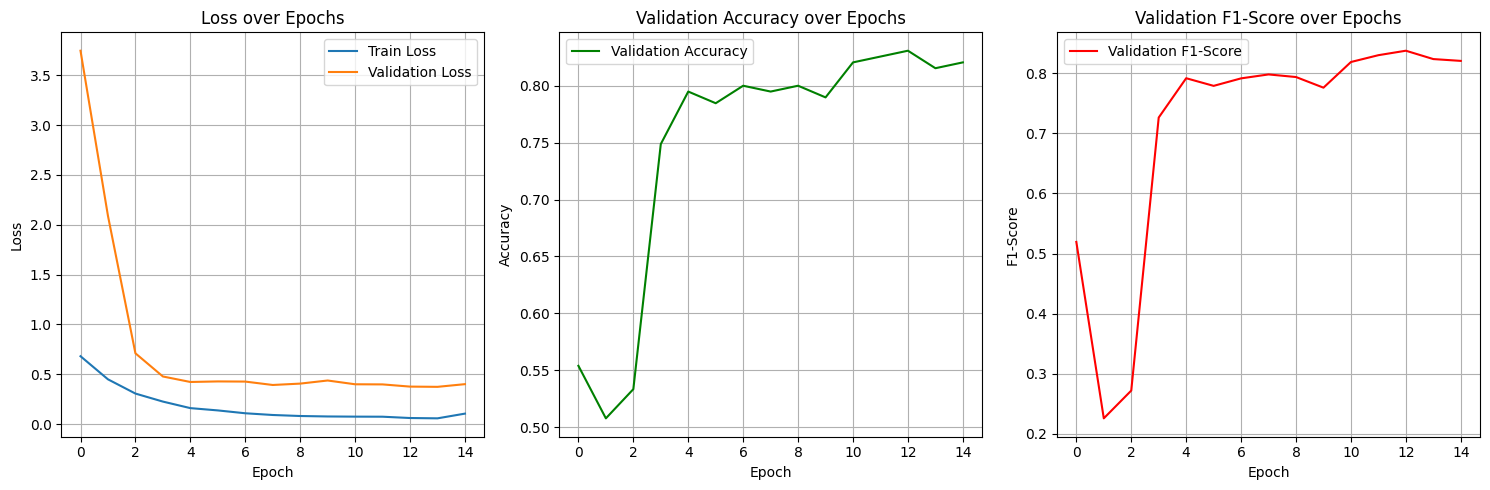

Training performance plots generated.


In [10]:
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot F1-Score
plt.subplot(1, 3, 3)
plt.plot(val_f1_scores, label='Validation F1-Score', color='red')
plt.title('Validation F1-Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print("Training performance plots generated.")


Cell 11: Final Evaluation and Confusion Matrix (Visual Proof)
Calculate and visualize the final performance metrics and a confusion matrix to understand misclassifications.

Action: Run this cell.

Output: Final metrics and a confusion matrix heatmap.


--- Final Validation Metrics (HybridForensicsNet) ---
Validation Loss: 0.4012
Validation Accuracy: 0.8205
Validation Precision: 0.9195
Validation Recall: 0.7407
Validation F1-Score: 0.8205
Validation AUC: 0.9092


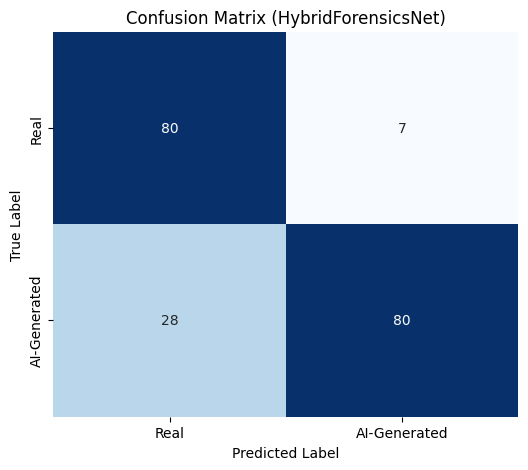


Final evaluation and confusion matrix generated.


In [11]:
# Re-run validation to get final preds and labels for confusion matrix
val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, true_labels, pred_labels = validate_model(model, val_loader, criterion, device)

print(f"\n--- Final Validation Metrics (HybridForensicsNet) ---")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real', 'AI-Generated'], yticklabels=['Real', 'AI-Generated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (HybridForensicsNet)')
plt.show()

print("\nFinal evaluation and confusion matrix generated.")


Cell 12: Identify and Save Misclassified Images (For Manual Review)
This cell identifies images where your model made the wrong prediction and copies them to a dedicated folder in your Google Drive for later manual analysis. This helps in understanding why the model failed.

Action: Run this cell.

Output: Paths to saved misclassified images.

In [12]:
import shutil
import os # Make sure os is imported, though it's likely imported in an earlier cell
import torch # Make sure torch is imported

# Create directories to save misclassified images
misclassified_dir = os.path.join(DRIVE_PATH, "misclassified_images")
os.makedirs(misclassified_dir, exist_ok=True)
misclassified_ai_as_real_dir = os.path.join(misclassified_dir, "AI_as_Real")
os.makedirs(misclassified_ai_as_real_dir, exist_ok=True)
misclassified_real_as_ai_dir = os.path.join(misclassified_dir, "Real_as_AI")
os.makedirs(misclassified_real_as_ai_dir, exist_ok=True)

model.eval()
print("Identifying misclassified images...")
with torch.no_grad():
    for idx in val_indices: # Iterate through validation set indices
        data_item = full_dataset[idx] # Get the raw item from the full dataset
        original_img_path = full_dataset.all_images[idx][0]
        true_label = data_item['label'].item()

        # Prepare inputs for the model
        rgb_inputs = data_item['rgb'].unsqueeze(0).to(device)
        fft_inputs = data_item['fft'].unsqueeze(0).to(device)
        wavelet_inputs = data_item['wavelet'].unsqueeze(0).to(device)
        ela_inputs = data_item['ela'].unsqueeze(0).to(device)

        outputs = model({'rgb': rgb_inputs, 'fft': fft_inputs, 'wavelet': wavelet_inputs, 'ela': ela_inputs})
        predicted_prob = torch.sigmoid(outputs).item()
        predicted_label = 1 if predicted_prob > 0.5 else 0

        if predicted_label != true_label:
            # Misclassified!
            filename = os.path.basename(original_img_path)
            if true_label == 1: # True is AI, Predicted is Real -> AI_as_Real
                dest_path = os.path.join(misclassified_ai_as_real_dir, filename)
                print(f"Misclassified AI as Real: {original_img_path} -> {dest_path}")
            else: # True is Real, Predicted is AI -> Real_as_AI
                dest_path = os.path.join(misclassified_real_as_ai_dir, filename)
                print(f"Misclassified Real as AI: {original_img_path} -> {dest_path}")

            try:
                shutil.copy(original_img_path, dest_path)
            except Exception as e:
                print(f"Error copying file {original_img_path}: {e}")

print("\nMisclassified image identification complete.")
print(f"Images misclassified as 'Real' are in: {misclassified_ai_as_real_dir}")
print(f"Images misclassified as 'AI' are in: {misclassified_real_as_ai_dir}")



Identifying misclassified images...
Misclassified AI as Real: /content/drive/MyDrive/AI gen Images/archive/AiArtData/AiArtData/ai-generated-animal-crossbreeds-06.jpg -> /content/drive/MyDrive/AI gen Images/archive/misclassified_images/AI_as_Real/ai-generated-animal-crossbreeds-06.jpg
Misclassified AI as Real: /content/drive/MyDrive/AI gen Images/archive/AiArtData/AiArtData/Midjourney-River.jpg -> /content/drive/MyDrive/AI gen Images/archive/misclassified_images/AI_as_Real/Midjourney-River.jpg
Misclassified AI as Real: /content/drive/MyDrive/AI gen Images/archive/AiArtData/AiArtData/hero-image.fill.size_1248x702.v1623363981.png -> /content/drive/MyDrive/AI gen Images/archive/misclassified_images/AI_as_Real/hero-image.fill.size_1248x702.v1623363981.png
Misclassified Real as AI: /content/drive/MyDrive/AI gen Images/archive/RealArt/RealArt/most-famous-paintings-by-jan-van-eyck.jpg -> /content/drive/MyDrive/AI gen Images/archive/misclassified_images/Real_as_AI/most-famous-paintings-by-jan-v

--- Task 1: Creating Master Output Folder ---
All outputs will be saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output

--- Task 2: Saving Final Model ---
Model state saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output/final_hybrid_model.pth

--- Task 3: Saving Final Evaluation Metrics ---
Text evaluation report saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output/final_evaluation_report.txt

FINAL MODEL EVALUATION METRICS (on Validation Set)
Validation Accuracy:  0.8205
Validation Precision: 0.9195
Validation Recall:    0.7407
Validation F1-Score:  0.8205
Validation AUC:       0.9092
CLASSIFICATION REPORT
              precision    recall  f1-score   support

Real Art (0)       0.74      0.92      0.82        87
  AI Art (1)       0.92      0.74      0.82       108

    accuracy                           0.82       195
   macro avg       0.83      0.83      0.82       195
weighted avg       0.84      0.82      0.82 

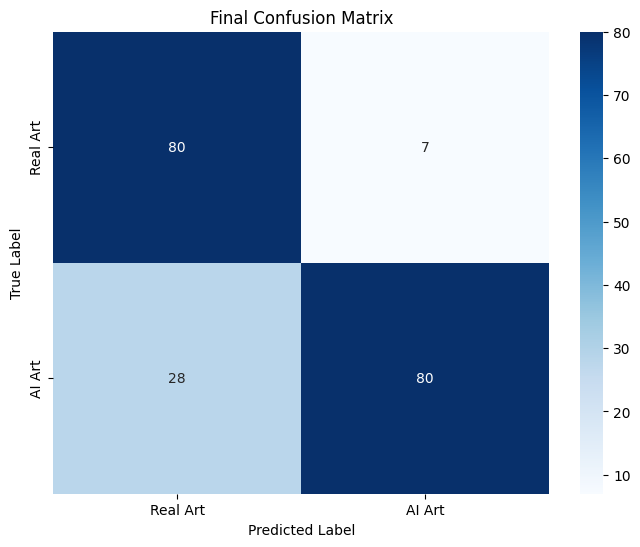

Confusion matrix plot saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output/final_confusion_matrix.png

--- Task 4: Test on New, Random Images ---
Results of random tests will be saved in: /content/drive/MyDrive/AI gen Images/archive/final_project_output/random_image_test_results
Please upload one or more images to test...


Saving predicted_HD-wallpaper-nature-scenery-scenery-nature.jpg to predicted_HD-wallpaper-nature-scenery-scenery-nature.jpg
Processing 1 uploaded images...
Could not process file predicted_HD-wallpaper-nature-scenery-scenery-nature.jpg. Error: name 'rgb_transform' is not defined

--- All tasks complete. ---


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files
from PIL import Image
import io

# --- 0. Define Helper Function for Single Image Prediction ---
# This function encapsulates all the preprocessing from earlier cells
# to predict a single, new image from a file path.

def predict_single_image(model, img_pil, device):
    """
    Applies all forensic preprocessing and predicts a single PIL image.
    Assumes preprocessing functions (apply_fft, apply_wavelet_transform, apply_ela)
    and transforms (rgb_transform, grayscale_transform, normalize_tensor) exist in the environment.
    """
    model.eval()

    # --- 1. Apply Forensic Preprocessing ---
    # Grayscale for forensic transforms (ensures consistency)
    img_pil_gray_resized = img_pil.resize((IMAGE_SIZE, IMAGE_SIZE))

    fft_img = apply_fft(img_pil_gray_resized)
    wavelet_img = apply_wavelet_transform(img_pil_gray_resized)
    ela_img = apply_ela(img_pil_gray_resized)
    ela_img_gray = ela_img.convert('L') # Fix from Cell 5

    # --- 2. Apply PyTorch Transforms ---
    rgb_tensor = rgb_transform(img_pil).unsqueeze(0).to(device)
    fft_tensor = normalize_tensor(grayscale_transform(fft_img)).unsqueeze(0).to(device)
    wavelet_tensor = normalize_tensor(grayscale_transform(wavelet_img)).unsqueeze(0).to(device)
    ela_tensor = normalize_tensor(grayscale_transform(ela_img_gray)).unsqueeze(0).to(device)

    # --- 3. Run Prediction ---
    with torch.no_grad():
        inputs = {
            'rgb': rgb_tensor,
            'fft': fft_tensor,
            'wavelet': wavelet_tensor,
            'ela': ela_tensor
        }
        output = model(inputs)
        predicted_prob = torch.sigmoid(output).item()

    predicted_label = "AI Art" if predicted_prob > 0.5 else "Real Art"

    return predicted_label, predicted_prob

# --- 1. Create a Master Output Folder ---
print("--- Task 1: Creating Master Output Folder ---")
output_folder = os.path.join(DRIVE_PATH, "final_project_output")
os.makedirs(output_folder, exist_ok=True)
print(f"All outputs will be saved to: {output_folder}")

# --- 2. Save the Final Model State ---
print("\n--- Task 2: Saving Final Model ---")
final_model_path = os.path.join(output_folder, "final_hybrid_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Model state saved to: {final_model_path}")

# --- 3. Save Final Evaluation Metrics ---
print("\n--- Task 3: Saving Final Evaluation Metrics ---")
# Get final metrics from the validation set
model.eval()
val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, all_labels, all_preds = validate_model(model, val_loader, criterion, device)

# A. Save Text Report
report_path = os.path.join(output_folder, "final_evaluation_report.txt")
binary_preds = (np.array(all_preds) > 0.5).astype(int)
report_str = classification_report(all_labels, binary_preds, target_names=['Real Art (0)', 'AI Art (1)'])

report_header = f"""
==================================================
FINAL MODEL EVALUATION METRICS (on Validation Set)
==================================================
Validation Accuracy:  {val_acc:.4f}
Validation Precision: {val_prec:.4f}
Validation Recall:    {val_rec:.4f}
Validation F1-Score:  {val_f1:.4f}
Validation AUC:       {val_auc:.4f}
==================================================
CLASSIFICATION REPORT
==================================================
{report_str}
"""
with open(report_path, 'w') as f:
    f.write(report_header)
print(f"Text evaluation report saved to: {report_path}")
print(report_header)

# B. Save Confusion Matrix Plot
cm_plot_path = os.path.join(output_folder, "final_confusion_matrix.png")
cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real Art', 'AI Art'],
            yticklabels=['Real Art', 'AI Art'])
plt.title('Final Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(cm_plot_path)
plt.show()
print(f"Confusion matrix plot saved to: {cm_plot_path}")

# --- 4. Test on Random, New Images ---
print("\n--- Task 4: Test on New, Random Images ---")
test_results_dir = os.path.join(output_folder, "random_image_test_results")
os.makedirs(test_results_dir, exist_ok=True)
print(f"Results of random tests will be saved in: {test_results_dir}")
print("Please upload one or more images to test...")

# Use Colab file uploader
uploaded = files.upload()

if not uploaded:
    print("No files uploaded. Skipping random image test.")
else:
    print(f"Processing {len(uploaded)} uploaded images...")
    for filename, data in uploaded.items():
        try:
            img_pil = Image.open(io.BytesIO(data)).convert('RGB')

            # Get prediction
            label, score = predict_single_image(model, img_pil, device)

            # Create a result plot
            plt.figure(figsize=(6, 8))
            plt.imshow(img_pil)
            plt.title(f"Prediction: {label}\nScore: {score:.4f}",
                      color=("red" if label == "AI Art" else "green"),
                      fontsize=14)
            plt.axis('off')

            # Save the result plot
            result_filename = f"predicted_{filename}.jpg"
            result_save_path = os.path.join(test_results_dir, result_filename)
            plt.savefig(result_save_path)
            plt.show()

            print(f"Saved prediction for {filename} to {result_save_path}")

        except Exception as e:
            print(f"Could not process file {filename}. Error: {e}")

print("\n--- All tasks complete. ---")


Cell 14: Define "Version 2" Dataset (With Augmentation & Transparency Fix)
This is a new version of your Cell 5. It adds random flips, rotations, and color jitter to your training data (to fight overfitting) and correctly handles transparent PNGs (to fix the warning).

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import random

print("Defining MultiForensicDatasetV2 (with Augmentation and Transparency Fix)...")

class MultiForensicDatasetV2(Dataset):
    def __init__(self, ai_path, real_path, img_size=224, is_train=True):
        self.ai_images = glob.glob(os.path.join(ai_path, '*.*'))
        self.real_images = glob.glob(os.path.join(real_path, '*.*'))
        self.all_images = [(img, 1) for img in self.ai_images] + [(img, 0) for img in self.real_images]

        if is_train:
            random.shuffle(self.all_images)

        self.img_size = img_size
        self.is_train = is_train

        # --- FIX 1: ADD AUGMENTATION ---
        # Define separate transforms for training (with augmentation) and validation (no augmentation)
        self.train_rgb_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.val_rgb_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.grayscale_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]

        # --- FIX 2: HANDLE TRANSPARENCY ---
        # Load image and ensure it's RGB
        img_pil = Image.open(img_path)
        if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
            # Create a new white background image
            background = Image.new('RGB', img_pil.size, (255, 255, 255))
            # Paste the RGBA image onto the white background, using its alpha channel as a mask
            background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
            img_pil = background
        else:
            img_pil = img_pil.convert('RGB')

        # Apply the correct transform (train vs val)
        if self.is_train:
            rgb_tensor = self.train_rgb_transform(img_pil)
        else:
            rgb_tensor = self.val_rgb_transform(img_pil)

        # Grayscale for forensic transforms
        img_pil_gray_resized = img_pil.resize((self.img_size, self.img_size))

        fft_img = apply_fft(img_pil_gray_resized)
        wavelet_img = apply_wavelet_transform(img_pil_gray_resized)
        ela_img = apply_ela(img_pil_gray_resized)
        ela_img_gray = ela_img.convert('L')

        # Convert forensic outputs to tensors
        fft_tensor = normalize_tensor(self.grayscale_transform(fft_img))
        wavelet_tensor = normalize_tensor(self.grayscale_transform(wavelet_img))
        ela_tensor = normalize_tensor(self.grayscale_transform(ela_img_gray))

        return {
            'rgb': rgb_tensor,
            'fft': fft_tensor,
            'wavelet': wavelet_tensor,
            'ela': ela_tensor,
            'label': torch.tensor(label, dtype=torch.float32)
        }

print("MultiForensicDatasetV2 class defined.")


Defining MultiForensicDatasetV2 (with Augmentation and Transparency Fix)...
MultiForensicDatasetV2 class defined.


Cell 15: Define "Version 2" Model (With Dropout Regularization)
This is a new version of your Cell 7. It adds a Dropout layer before the final classifier. This randomly "turns off" neurons during training, forcing the model to learn more robust features and further preventing overfitting.

In [19]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

print("Re-defining training/validation functions to support mixed precision (AMP)...")

def train_one_epoch(model, train_loader, criterion, optimizer, device, scaler):
    """
    MODIFIED train_one_epoch function that accepts and uses a GradScaler (scaler).
    """
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for batch in progress_bar:
        # Move to device
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        labels = batch['label'].to(device).unsqueeze(1)

        optimizer.zero_grad()

        # --- AMP ---
        # Forward pass with autocast
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # --- AMP ---
        # Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

def validate_model(model, val_loader, criterion, device):
    """
    MODIFIED validate_model function that uses autocast for validation.
    """
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validating", leave=False)
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(device).unsqueeze(1)

            # --- AMP ---
            # Forward pass with autocast for consistency
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    binary_preds = (all_preds > 0.5).astype(int)

    val_loss_avg = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, binary_preds)
    val_prec = precision_score(all_labels, binary_preds, zero_division=0)
    val_rec = recall_score(all_labels, binary_preds, zero_division=0)
    val_f1 = f1_score(all_labels, binary_preds, zero_division=0)

    try:
        val_auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        val_auc = 0.5 # Handle cases with only one class in batch

    return val_loss_avg, val_acc, val_prec, val_rec, val_f1, val_auc, all_labels, all_preds

print("Training functions updated.")


Re-defining training/validation functions to support mixed precision (AMP)...
Training functions updated.


Cell 16: Re-Train the "Version 2" Model
This cell re-creates your datasets and DataLoaders using the new V2 classes and then trains the new V2 model from scratch.

In [20]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import time
import os

print("--- Preparing V2 DataLoaders ---")
# Create new V2 datasets
train_dataset_v2 = MultiForensicDatasetV2(AI_GEN_IMAGES_PATH, REAL_ART_IMAGES_PATH, img_size=IMAGE_SIZE, is_train=True)
val_dataset_v2 = MultiForensicDatasetV2(AI_GEN_IMAGES_PATH, REAL_ART_IMAGES_PATH, img_size=IMAGE_SIZE, is_train=False)

# Use the same val_indices from Cell 6 to ensure a consistent test set
# If val_indices is not in memory, you must re-run Cell 6 first.
try:
    _ = val_indices
except NameError:
    print("WARNING: val_indices not found. Re-running logic from Cell 6...")
    all_indices = list(range(len(train_dataset_v2))) # Use V2 dataset length
    train_indices, val_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

# Create subsets using the new V2 datasets
train_subset_v2 = Subset(train_dataset_v2, train_indices)
val_subset_v2 = Subset(val_dataset_v2, val_indices) # Use V2 validation dataset

# Create new V2 DataLoaders
train_loader_v2 = DataLoader(train_subset_v2, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_v2 = DataLoader(val_subset_v2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"V2 Train subset size: {len(train_subset_v2)}")
print(f"V2 Val subset size: {len(val_subset_v2)}")

# --- Re-Initialize V2 Model, Optimizer, etc. ---
print("\n--- Initializing V2 Model ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

model_v2 = HybridForensicsNetV2().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_v2.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

best_val_f1_v2 = 0.0
model_save_path_v2 = os.path.join(DRIVE_PATH, "hybrid_model_v2_best.pth")

print("Starting training for HybridForensicsNetV2...")
# --- Re-Training Loop ---
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # Train
    train_loss = train_one_epoch(model_v2, train_loader_v2, criterion, optimizer, device, scaler)

    # Validate
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = validate_model(model_v2, val_loader_v2, criterion, device)

    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1:.4f} | "
          f"Val AUC: {val_auc:.4f} | Time: {epoch_time:.1f}s")

    # Save the best model based on F1 score
    if val_f1 > best_val_f1_v2:
        best_val_f1_v2 = val_f1
        torch.save(model_v2.state_dict(), model_save_path_v2)
        print(f"  -> New best model saved with F1: {val_f1:.4f} at {model_save_path_v2}")

print(f"\nTraining complete. Best V2 model saved to {model_save_path_v2} with F1: {best_val_f1_v2:.4f}")


--- Preparing V2 DataLoaders ---
V2 Train subset size: 777
V2 Val subset size: 195

--- Initializing V2 Model ---
Training on device: cuda


/tmp/ipython-input-178403823.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting training for HybridForensicsNetV2...


Training:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train Loss: 0.6500 | Val Loss: 3.3473 | Val Acc: 0.5897 | Val Prec: 0.6531 | Val Rec: 0.5818 | Val F1: 0.6154 | Val AUC: 0.6181 | Time: 81.5s
  -> New best model saved with F1: 0.6154 at /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth


Training:  16%|█▌        | 4/25 [00:08<00:38,  1.85s/it, loss=0.461]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/15 | Train Loss: 0.3998 | Val Loss: 0.7466 | Val Acc: 0.4923 | Val Prec: 0.9231 | Val Rec: 0.1091 | Val F1: 0.1951 | Val AUC: 0.8489 | Time: 56.4s


Training:  48%|████▊     | 12/25 [00:24<00:22,  1.73s/it, loss=0.245]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/15 | Train Loss: 0.2560 | Val Loss: 0.6589 | Val Acc: 0.5641 | Val Prec: 1.0000 | Val Rec: 0.2273 | Val F1: 0.3704 | Val AUC: 0.9343 | Time: 56.2s


Training:   8%|▊         | 2/25 [00:03<00:38,  1.67s/it, loss=0.164]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  36%|███▌      | 9/25 [00:16<00:25,  1.57s/it, loss=0.183]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/15 | Train Loss: 0.1562 | Val Loss: 0.2244 | Val Acc: 0.9436 | Val Prec: 0.9626 | Val Rec: 0.9364 | Val F1: 0.9493 | Val AUC: 0.9837 | Time: 55.8s
  -> New best model saved with F1: 0.9493 at /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth


Training:  20%|██        | 5/25 [00:13<00:56,  2.81s/it, loss=0.11]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/15 | Train Loss: 0.1031 | Val Loss: 0.1239 | Val Acc: 0.9487 | Val Prec: 0.9630 | Val Rec: 0.9455 | Val F1: 0.9541 | Val AUC: 0.9913 | Time: 57.8s
  -> New best model saved with F1: 0.9541 at /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth


Training:  40%|████      | 10/25 [00:22<00:27,  1.84s/it, loss=0.0715]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  76%|███████▌  | 19/25 [00:39<00:10,  1.67s/it, loss=0.0739]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/15 | Train Loss: 0.0776 | Val Loss: 0.1194 | Val Acc: 0.9538 | Val Prec: 0.9720 | Val Rec: 0.9455 | Val F1: 0.9585 | Val AUC: 0.9918 | Time: 57.7s
  -> New best model saved with F1: 0.9585 at /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth


Training:  12%|█▏        | 3/25 [00:06<00:41,  1.89s/it, loss=0.0469]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/15 | Train Loss: 0.0599 | Val Loss: 0.1169 | Val Acc: 0.9538 | Val Prec: 0.9720 | Val Rec: 0.9455 | Val F1: 0.9585 | Val AUC: 0.9909 | Time: 58.6s


Training:   8%|▊         | 2/25 [00:03<00:38,  1.65s/it, loss=0.0427]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  76%|███████▌  | 19/25 [00:36<00:10,  1.75s/it, loss=0.03]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/15 | Train Loss: 0.0445 | Val Loss: 0.1069 | Val Acc: 0.9538 | Val Prec: 0.9810 | Val Rec: 0.9364 | Val F1: 0.9581 | Val AUC: 0.9936 | Time: 56.4s


Training:   8%|▊         | 2/25 [00:05<00:55,  2.40s/it, loss=0.0314]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  72%|███████▏  | 18/25 [00:35<00:09,  1.31s/it, loss=0.0767]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/15 | Train Loss: 0.0411 | Val Loss: 0.1083 | Val Acc: 0.9590 | Val Prec: 0.9722 | Val Rec: 0.9545 | Val F1: 0.9633 | Val AUC: 0.9924 | Time: 57.2s
  -> New best model saved with F1: 0.9633 at /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth


Training:  20%|██        | 5/25 [00:14<01:07,  3.39s/it, loss=0.0237]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/15 | Train Loss: 0.0358 | Val Loss: 0.1027 | Val Acc: 0.9590 | Val Prec: 0.9722 | Val Rec: 0.9545 | Val F1: 0.9633 | Val AUC: 0.9926 | Time: 58.9s


Training:  72%|███████▏  | 18/25 [00:35<00:12,  1.84s/it, loss=0.0569]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/15 | Train Loss: 0.0456 | Val Loss: 0.1113 | Val Acc: 0.9590 | Val Prec: 0.9722 | Val Rec: 0.9545 | Val F1: 0.9633 | Val AUC: 0.9923 | Time: 56.0s


Training:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/15 | Train Loss: 0.0261 | Val Loss: 0.0959 | Val Acc: 0.9487 | Val Prec: 0.9717 | Val Rec: 0.9364 | Val F1: 0.9537 | Val AUC: 0.9940 | Time: 56.5s


Training:  16%|█▌        | 4/25 [00:08<00:41,  1.96s/it, loss=0.0161]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  24%|██▍       | 6/25 [00:11<00:29,  1.58s/it, loss=0.0399]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13/15 | Train Loss: 0.0324 | Val Loss: 0.1016 | Val Acc: 0.9590 | Val Prec: 0.9904 | Val Rec: 0.9364 | Val F1: 0.9626 | Val AUC: 0.9930 | Time: 57.3s


Training:  20%|██        | 5/25 [00:10<00:36,  1.84s/it, loss=0.0162]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14/15 | Train Loss: 0.0323 | Val Loss: 0.1075 | Val Acc: 0.9538 | Val Prec: 0.9810 | Val Rec: 0.9364 | Val F1: 0.9581 | Val AUC: 0.9930 | Time: 57.4s


Training:  60%|██████    | 15/25 [00:31<00:23,  2.36s/it, loss=0.0192]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
                                                         

Epoch 15/15 | Train Loss: 0.0228 | Val Loss: 0.1089 | Val Acc: 0.9487 | Val Prec: 0.9717 | Val Rec: 0.9364 | Val F1: 0.9537 | Val AUC: 0.9923 | Time: 56.5s

Training complete. Best V2 model saved to /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth with F1: 0.9633


Cell 17: Save All V2 Metrics & Test on Random Images
This is your new "final" cell. It saves all metrics and tests the new model_v2. It saves everything to a new folder, final_project_output_v2, so you don't overwrite your previous results.

Loading best V2 model for final evaluation...
--- Task 1: Creating Master V2 Output Folder ---
All V2 outputs will be saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2

--- Task 2: Copying Final V2 Model ---
Final V2 model state saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/final_hybrid_model_v2.pth

--- Task 3: Saving Final V2 Evaluation Metrics ---


V2 Text evaluation report saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/final_evaluation_report_v2.txt

FINAL V2 MODEL EVALUATION METRICS (on Validation Set)
Validation Accuracy:  0.9590
Validation Precision: 0.9722
Validation Recall:    0.9545
Validation F1-Score:  0.9633
Validation AUC:       0.9924
CLASSIFICATION REPORT
              precision    recall  f1-score   support

Real Art (0)       0.94      0.96      0.95        85
  AI Art (1)       0.97      0.95      0.96       110

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195




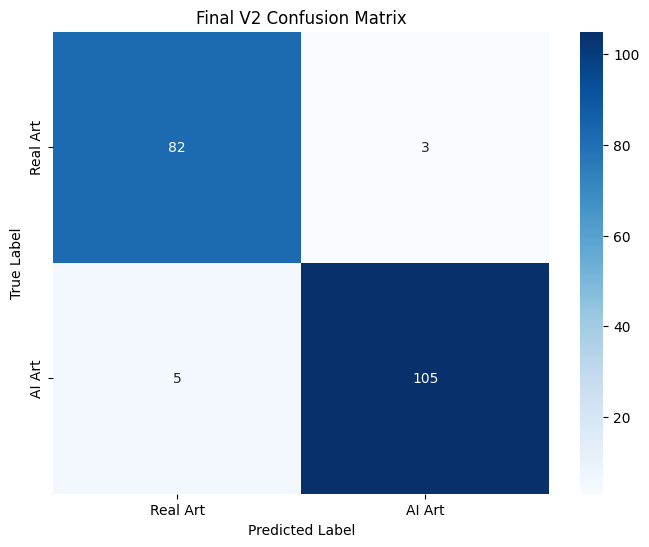

VS Confusion matrix plot saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/final_confusion_matrix_v2.png

--- Task 4: Test on New, Random Images (V2 Model) ---
Results of random tests will be saved in: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/random_image_test_results_v2
Please upload one or more images to test...


Saving predicted_HD-wallpaper-nature-scenery-scenery-nature.jpg to predicted_HD-wallpaper-nature-scenery-scenery-nature (1).jpg
Processing 1 uploaded images...


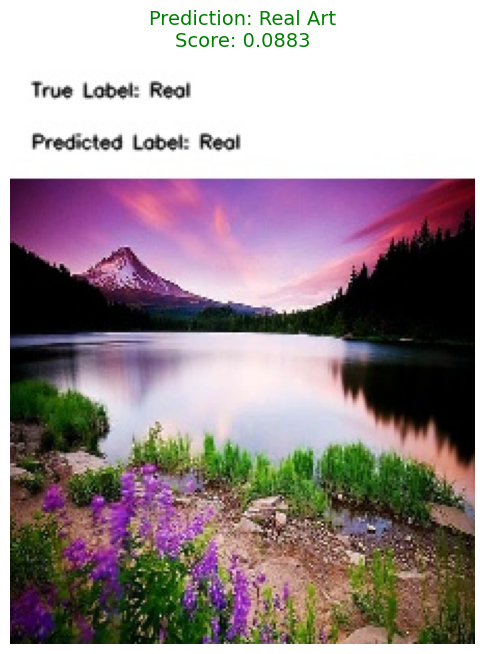

Saved prediction for predicted_HD-wallpaper-nature-scenery-scenery-nature (1).jpg to /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/random_image_test_results_v2/predicted_v2_predicted_HD-wallpaper-nature-scenery-scenery-nature (1).jpg.jpg

--- All V2 tasks complete. ---


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files
from PIL import Image
import io

# --- 0. Make sure the V2 model is loaded ---
# Load the best performing V2 model we just trained
print("Loading best V2 model for final evaluation...")
model_v2 = HybridForensicsNetV2().to(device) # Re-init architecture
model_v2.load_state_dict(torch.load(model_save_path_v2)) # Load best weights
model_v2.eval() # Set to evaluation mode

# --- 1. Create a Master Output Folder for V2 ---
print("--- Task 1: Creating Master V2 Output Folder ---")
output_folder_v2 = os.path.join(DRIVE_PATH, "final_project_output_v2")
os.makedirs(output_folder_v2, exist_ok=True)
print(f"All V2 outputs will be saved to: {output_folder_v2}")

# --- 2. Save the Final V2 Model State (already done, but good to copy) ---
print("\n--- Task 2: Copying Final V2 Model ---")
final_model_path_v2 = os.path.join(output_folder_v2, "final_hybrid_model_v2.pth")
torch.save(model_v2.state_dict(), final_model_path_v2)
print(f"Final V2 model state saved to: {final_model_path_v2}")

# --- 3. Save Final V2 Evaluation Metrics ---
print("\n--- Task 3: Saving Final V2 Evaluation Metrics ---")
# Get final metrics from the V2 validation set
val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, all_labels, all_preds = validate_model(model_v2, val_loader_v2, criterion, device)

# A. Save Text Report
report_path_v2 = os.path.join(output_folder_v2, "final_evaluation_report_v2.txt")
binary_preds = (np.array(all_preds) > 0.5).astype(int)
report_str = classification_report(all_labels, binary_preds, target_names=['Real Art (0)', 'AI Art (1)'])

report_header = f"""
==================================================
FINAL V2 MODEL EVALUATION METRICS (on Validation Set)
==================================================
Validation Accuracy:  {val_acc:.4f}
Validation Precision: {val_prec:.4f}
Validation Recall:    {val_rec:.4f}
Validation F1-Score:  {val_f1:.4f}
Validation AUC:       {val_auc:.4f}
==================================================
CLASSIFICATION REPORT
==================================================
{report_str}
"""
with open(report_path_v2, 'w') as f:
    f.write(report_header)
print(f"V2 Text evaluation report saved to: {report_path_v2}")
print(report_header)

# B. Save Confusion Matrix Plot
cm_plot_path_v2 = os.path.join(output_folder_v2, "final_confusion_matrix_v2.png")
cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real Art', 'AI Art'],
            yticklabels=['Real Art', 'AI Art'])
plt.title('Final V2 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(cm_plot_path_v2)
plt.show()
print(f"VS Confusion matrix plot saved to: {cm_plot_path_v2}")

# --- 4. Test on Random, New Images (using V2 model) ---
print("\n--- Task 4: Test on New, Random Images (V2 Model) ---")
test_results_dir_v2 = os.path.join(output_folder_v2, "random_image_test_results_v2")
os.makedirs(test_results_dir_v2, exist_ok=True)
print(f"Results of random tests will be saved in: {test_results_dir_v2}")
print("Please upload one or more images to test...")

# Use Colab file uploader
uploaded = files.upload()

if not uploaded:
    print("No files uploaded. Skipping random image test.")
else:
    print(f"Processing {len(uploaded)} uploaded images...")
    for filename, data in uploaded.items():
        try:
            # We must use the V2 image loading logic (with transparency fix)
            img_pil = Image.open(io.BytesIO(data))
            if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
                background = Image.new('RGB', img_pil.size, (255, 255, 255))
                background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
                img_pil = background
            else:
                img_pil = img_pil.convert('RGB')

            # Get prediction using the V2 model
            # We must re-define the predict_single_image function here to use the V2 transforms

            # --- Re-define V2 prediction function ---
            # (Requires access to V2 transforms)
            val_rgb_transform = train_dataset_v2.val_rgb_transform
            grayscale_transform = train_dataset_v2.grayscale_transform

            img_pil_gray_resized = img_pil.resize((IMAGE_SIZE, IMAGE_SIZE))
            fft_img = apply_fft(img_pil_gray_resized)
            wavelet_img = apply_wavelet_transform(img_pil_gray_resized)
            ela_img = apply_ela(img_pil_gray_resized)
            ela_img_gray = ela_img.convert('L')

            rgb_tensor = val_rgb_transform(img_pil).unsqueeze(0).to(device)
            fft_tensor = normalize_tensor(grayscale_transform(fft_img)).unsqueeze(0).to(device)
            wavelet_tensor = normalize_tensor(grayscale_transform(wavelet_img)).unsqueeze(0).to(device)
            ela_tensor = normalize_tensor(grayscale_transform(ela_img_gray)).unsqueeze(0).to(device)

            with torch.no_grad():
                inputs = {'rgb': rgb_tensor, 'fft': fft_tensor, 'wavelet': wavelet_tensor, 'ela': ela_tensor}
                output = model_v2(inputs)
                score = torch.sigmoid(output).item()

            label = "AI Art" if score > 0.5 else "Real Art"
            # --- End re-defined prediction ---

            # Create a result plot
            plt.figure(figsize=(6, 8))
            plt.imshow(img_pil)
            plt.title(f"Prediction: {label}\nScore: {score:.4f}",
                      color=("red" if label == "AI Art" else "green"),
                      fontsize=14)
            plt.axis('off')

            # Save the result plot
            result_filename = f"predicted_v2_{filename}.jpg"
            result_save_path = os.path.join(test_results_dir_v2, result_filename)
            plt.savefig(result_save_path)
            plt.show()

            print(f"Saved prediction for {filename} to {result_save_path}")

        except Exception as e:
            print(f"Could not process file {filename}. Error: {e}")

print("\n--- All V2 tasks complete. ---")


Cell 18: Predict and Save 25 Random Validation Images

In [22]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import io

print("--- Starting Random Image Prediction Task ---")

# --- 1. Define Constants and Output Folder ---
NUM_IMAGES_TO_TEST = 25
PREDICTION_OUTPUT_DIR = os.path.join(DRIVE_PATH, "final_project_output_v2", "random_dataset_predictions")
os.makedirs(PREDICTION_OUTPUT_DIR, exist_ok=True)
print(f"Prediction results will be saved to: {PREDICTION_OUTPUT_DIR}")

# --- 2. Load the Best V2 Model ---
try:
    # Ensure model architecture is defined (by running Cell 15)
    model_v2 = HybridForensicsNetV2().to(device)

    # Load the best weights saved during training (from Cell 16)
    model_v2.load_state_dict(torch.load(model_save_path_v2))
    model_v2.eval() # Set model to evaluation mode
    print(f"Successfully loaded best V2 model from: {model_save_path_v2}")

    # Also ensure dataset objects are defined (by running Cell 16)
    _ = val_dataset_v2
    _ = val_indices

except NameError as e:
    print(f"ERROR: A required object (model, dataset, or indices) is not defined.")
    print(f"Please re-run Cell 15 (to define model) and Cell 16 (to define dataset) before running this cell.")
    print(f"Details: {e}")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

# --- 3. Get Random Sample Indices ---
# Select 25 random indices from our validation set
if len(val_indices) < NUM_IMAGES_TO_TEST:
    print(f"Warning: Not enough images in validation set ({len(val_indices)}) to pick {NUM_IMAGES_TO_TEST}. Using all.")
    random_val_indices = val_indices
else:
    random_val_indices = random.sample(val_indices, NUM_IMAGES_TO_TEST)

print(f"Selected {len(random_val_indices)} random images from the validation set for testing...")

# --- 4. Loop, Predict, and Save ---
for i, global_index in enumerate(random_val_indices):

    # A. Get the data item from the V2 validation dataset
    # This item contains all our pre-processed tensors
    data_item = val_dataset_v2[global_index]

    # B. Get original image path and true label
    original_img_path, true_label_int = val_dataset_v2.all_images[global_index]
    true_label_str = "AI Art" if true_label_int == 1 else "Real Art"

    # C. Prepare batch-of-1 for the model
    inputs = {
        'rgb': data_item['rgb'].unsqueeze(0).to(device),
        'fft': data_item['fft'].unsqueeze(0).to(device),
        'wavelet': data_item['wavelet'].unsqueeze(0).to(device),
        'ela': data_item['ela'].unsqueeze(0).to(device)
    }

    # D. Run Prediction
    with torch.no_grad():
        output = model_v2(inputs)
        score = torch.sigmoid(output).item()

    pred_label_int = 1 if score > 0.5 else 0
    pred_label_str = "AI Art" if pred_label_int == 1 else "Real Art"

    # E. Print to console
    result_color = "\033[92m" if true_label_int == pred_label_int else "\033[91m" # Green for correct, Red for incorrect
    print(f"\nImage {i+1}/{NUM_IMAGES_TO_TEST} ({os.path.basename(original_img_path)}):")
    print(f"  > True Label:     {true_label_str}")
    print(f"{result_color}  > Predicted Label: {pred_label_str} (Score: {score:.4f})\033[0m")

    # F. Open original image and save with text overlay
    try:
        # We must use the V2 image loading logic (with transparency fix)
        img_pil = Image.open(original_img_path)
        if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
            background = Image.new('RGB', img_pil.size, (255, 255, 255))
            background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
            img_pil = background
        else:
            img_pil = img_pil.convert('RGB')

        draw = ImageDraw.Draw(img_pil)

        # Try to load a font, fallback to default
        try:
            # Colab's default font
            font = ImageFont.truetype("LiberationSans-Regular.ttf", size=24)
        except IOError:
            font = ImageFont.load_default()

        # Define text and colors
        text_true = f"True: {true_label_str}"
        text_pred = f"Pred: {pred_label_str} ({score:.2f})"
        color_true = (0, 180, 0) # Green
        color_pred = (0, 180, 0) if true_label_int == pred_label_int else (255, 0, 0) # Green if correct, Red if wrong

        # Draw text with a simple black outline
        draw.text((10, 11), text_true, font=font, fill=(0,0,0))
        draw.text((10, 10), text_true, font=font, fill=color_true)

        draw.text((10, 41), text_pred, font=font, fill=(0,0,0))
        draw.text((10, 40), text_pred, font=font, fill=color_pred)

        # Save the image
        save_filename = f"{i+1}__{'CORRECT' if true_label_int == pred_label_int else 'WRONG'}__{os.path.basename(original_img_path)}"
        img_pil.save(os.path.join(PREDICTION_OUTPUT_DIR, save_filename))

    except Exception as e:
        print(f"  ! Error saving image overlay: {e}")

print("\n--- Random prediction task complete. ---")


--- Starting Random Image Prediction Task ---
Prediction results will be saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/random_dataset_predictions
Successfully loaded best V2 model from: /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth
Selected 25 random images from the validation set for testing...

Image 1/25 (dwayne-johnson-attends-the-premiere-of-universal-pictures-news-photo-1161880409-1566504158.jpg):
  > True Label:     Real Art
  > Predicted Label: Real Art (Score: 0.0035)

Image 2/25 (Deepfake-AI-generated-2023.jpg):
  > True Label:     AI Art
  > Predicted Label: AI Art (Score: 0.9836)

Image 3/25 (group-people-illustration-set_52683-33806.jpg):
  > True Label:     Real Art
  > Predicted Label: Real Art (Score: 0.0079)

Image 4/25 (lamb-iStock-665494268-16x9-e1559777676675-1200x675.jpg):
  > True Label:     Real Art
  > Predicted Label: Real Art (Score: 0.0066)

Image 5/25 (180222162827-the-kiss-story-top-card-image.jpg):
 

Cell 19: ROC Curve and Confidence Analysis

--- Starting ROC Curve & Confidence Analysis Task ---
Successfully loaded best V2 model from: /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth
Running model on entire validation set to gather all predictions...


Validation run complete.
Generating ROC Curve...
ROC Curve saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/random_dataset_predictions/final_roc_curve.png


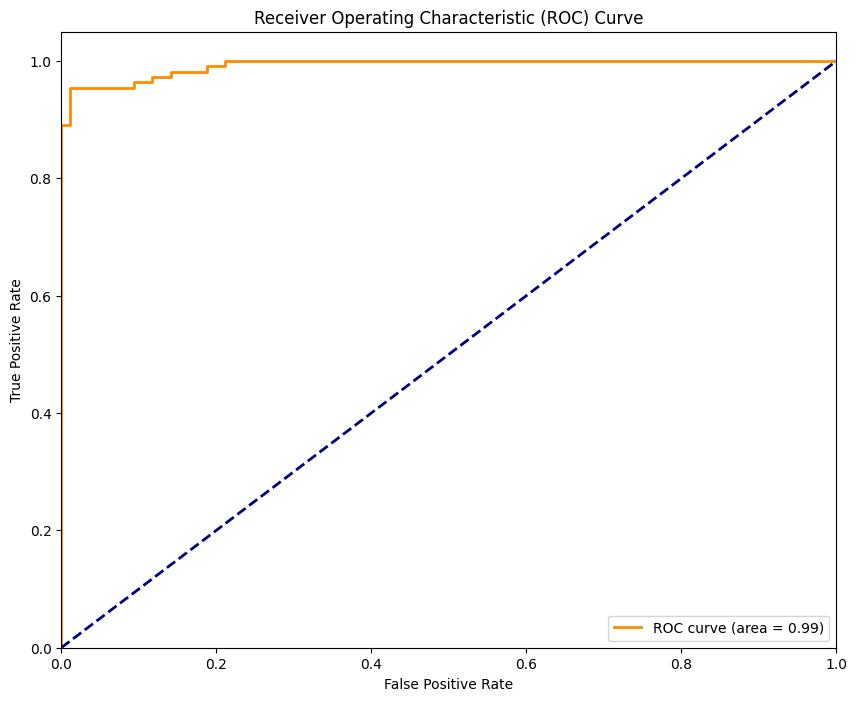

Generating Confidence Histograms...
Confidence histogram saved to: /content/drive/MyDrive/AI gen Images/archive/final_project_output_v2/random_dataset_predictions/final_confidence_histogram.png


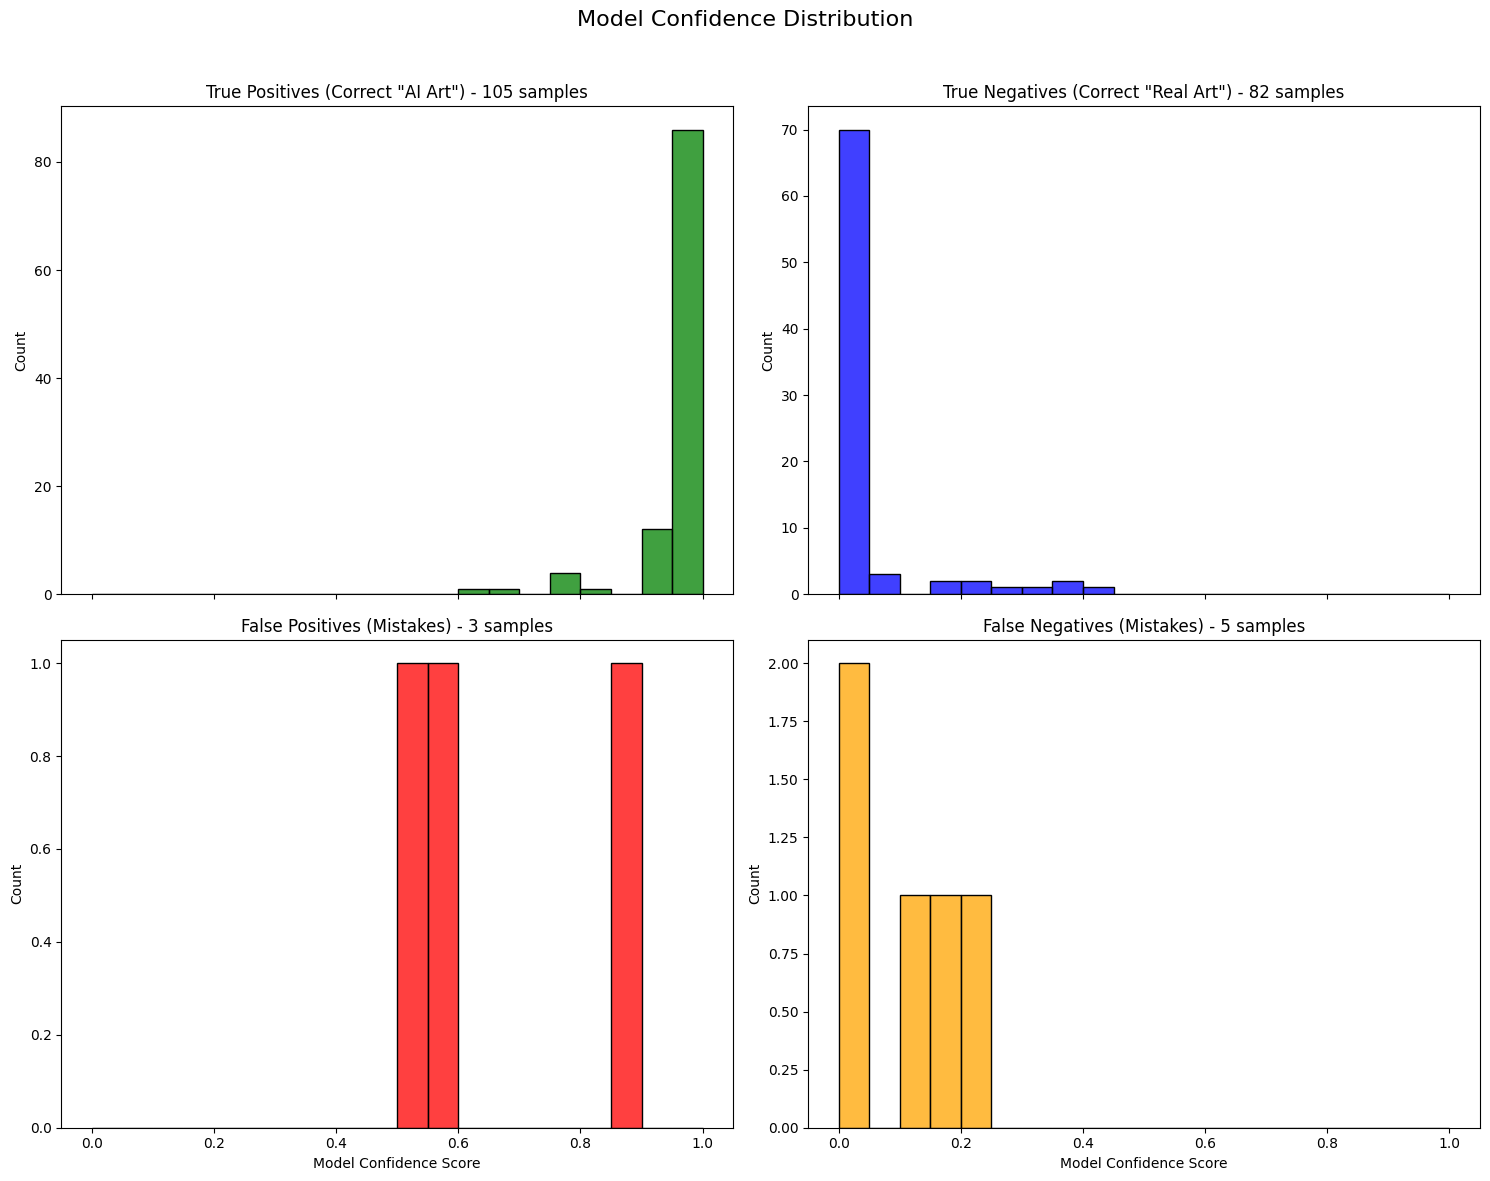


--- Analysis complete. ---


In [23]:
import torch
import torch.nn as nn
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting ROC Curve & Confidence Analysis Task ---")

# --- 1. Load the Best V2 Model (if not already loaded) ---
try:
    # Ensure model architecture is defined (by running Cell 15)
    model_v2 = HybridForensicsNetV2().to(device)

    # Load the best weights saved during training (from Cell 16)
    model_v2.load_state_dict(torch.load(model_save_path_v2))
    model_v2.eval() # Set model to evaluation mode
    print(f"Successfully loaded best V2 model from: {model_save_path_v2}")

    # Also ensure dataset objects are defined (by running Cell 16)
    _ = val_dataset_v2
    _ = val_loader_v2

except NameError as e:
    print(f"ERROR: A required object (model, dataset, or loader) is not defined.")
    print(f"Please re-run Cell 15 and Cell 16 before running this cell.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

# --- 2. Run Full Validation to Get All Predictions ---
print("Running model on entire validation set to gather all predictions...")

all_labels = []
all_preds_scores = [] # Store the raw sigmoid scores (probabilities)

with torch.no_grad():
    progress_bar = tqdm(val_loader_v2, desc="Validating", leave=False)
    for batch in progress_bar:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        labels = batch['label'].to(device).unsqueeze(1)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model_v2(inputs)
            preds = torch.sigmoid(outputs)

        all_labels.extend(labels.cpu().numpy())
        all_preds_scores.extend(preds.cpu().numpy())

all_labels = np.array(all_labels).flatten()
all_preds_scores = np.array(all_preds_scores).flatten()
all_binary_preds = (all_preds_scores > 0.5).astype(int)

print("Validation run complete.")

# --- 3. Plot ROC Curve ---
print("Generating ROC Curve...")
fpr, tpr, thresholds = roc_curve(all_labels, all_preds_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot
roc_save_path = os.path.join(PREDICTION_OUTPUT_DIR, "final_roc_curve.png")
plt.savefig(roc_save_path)
print(f"ROC Curve saved to: {roc_save_path}")
plt.show()

# --- 4. Plot Confidence Histograms ---
print("Generating Confidence Histograms...")

# Separate predictions into four categories
tp = all_preds_scores[(all_labels == 1) & (all_binary_preds == 1)]
tn = all_preds_scores[(all_labels == 0) & (all_binary_preds == 0)]
fp = all_preds_scores[(all_labels == 0) & (all_binary_preds == 1)]
fn = all_preds_scores[(all_labels == 1) & (all_binary_preds == 0)]

fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
fig.suptitle('Model Confidence Distribution', fontsize=16)

# Plot True Positives (Correct AI Art)
sns.histplot(tp, ax=axes[0, 0], color='green', bins=20, binrange=(0,1))
axes[0, 0].set_title(f'True Positives (Correct "AI Art") - {len(tp)} samples')
axes[0, 0].set_ylabel('Count')

# Plot True Negatives (Correct Real Art)
sns.histplot(tn, ax=axes[0, 1], color='blue', bins=20, binrange=(0,1))
axes[0, 1].set_title(f'True Negatives (Correct "Real Art") - {len(tn)} samples')

# Plot False Positives (Incorrect "AI Art")
sns.histplot(fp, ax=axes[1, 0], color='red', bins=20, binrange=(0,1))
axes[1, 0].set_title(f'False Positives (Mistakes) - {len(fp)} samples')
axes[1, 0].set_xlabel('Model Confidence Score')
axes[1, 0].set_ylabel('Count')

# Plot False Negatives (Incorrect "Real Art")
sns.histplot(fn, ax=axes[1, 1], color='orange', bins=20, binrange=(0,1))
axes[1, 1].set_title(f'False Negatives (Mistakes) - {len(fn)} samples')
axes[1, 1].set_xlabel('Model Confidence Score')

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot
conf_save_path = os.path.join(PREDICTION_OUTPUT_DIR, "final_confidence_histogram.png")
plt.savefig(conf_save_path)
print(f"Confidence histogram saved to: {conf_save_path}")
plt.show()

print("\n--- Analysis complete. ---")


Cell 20: Interactive Dataset Cleaning Tool

In [25]:
import os
import shutil
from IPython.display import display, clear_output
from PIL import Image
import ipywidgets as widgets

print("--- Starting Interactive Dataset Cleaning Tool ---")

# --- 1. Define Your New "Clean" Directories ---
try:
    CLEAN_DATA_DIR = os.path.join(DRIVE_PATH, "Cleaned_Dataset_v2") # V2 to be safe
    CLEAN_AI_DIR = os.path.join(CLEAN_DATA_DIR, "AiArtData")
    CLEAN_REAL_DIR = os.path.join(CLEAN_DATA_DIR, "RealArt")

    os.makedirs(CLEAN_AI_DIR, exist_ok=True)
    os.makedirs(CLEAN_REAL_DIR, exist_ok=True)

    print(f"Cleaned images will be saved to:")
    print(f"  AI Art: {CLEAN_AI_DIR}")
    print(f"  Real Art: {CLEAN_REAL_DIR}")

except NameError:
    print("ERROR: 'DRIVE_PATH' not found. Please re-run Cell 2 to define it.")
    raise

# --- 2. Get All Original Image Paths (from Cell 6) ---
try:
    # Assumes full_dataset is in memory from Cell 6
    all_original_images = full_dataset.all_images
    print(f"Found {len(all_original_images)} total images to review.")
except NameError:
    print("ERROR: 'full_dataset' not found. Please re-run Cell 6 to define it.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

# --- 3. The Interactive Review Loop (Button-based) ---

# Global state
current_index = 0

# --- Define Widgets ---
# Output widget for images and text
img_display = widgets.Output()
progress_text = widgets.HTML(value="Starting...")

# Create buttons
keep_button = widgets.Button(description="Keep (y)", button_style='success', icon='check')
skip_button = widgets.Button(description="Skip (n)", button_style='warning', icon='times')
quit_button = widgets.Button(description="Quit (q)", button_style='danger', icon='stop')

# Arrange buttons horizontally
button_box = widgets.HBox([keep_button, skip_button, quit_button])

# --- Define Helper Functions ---
def show_next_image():
    """Displays the image and info for the current_index."""
    global current_index

    # Check if we are done
    if current_index >= len(all_original_images):
        with img_display:
            clear_output(wait=True)
            print("--- REVIEW COMPLETE ---")
            print(f"All {len(all_original_images)} images have been reviewed.")
        progress_text.value = f"Review Complete! {current_index}/{len(all_original_images)}"
        # Disable buttons
        keep_button.disabled = True
        skip_button.disabled = True
        quit_button.disabled = True
        return

    # Get image path and label
    img_path, label = all_original_images[current_index]

    try:
        # Display the image
        with img_display:
            clear_output(wait=True)
            img = Image.open(img_path)
            img.thumbnail((400, 400)) # Resize to show in output
            display(img)

        # Update progress text
        progress_text.value = (
            f"Image {current_index + 1}/{len(all_original_images)}: {os.path.basename(img_path)}<br>"
            f"Original Label: {'AI Art' if label == 1 else 'Real Art'}"
        )

    except Exception as e:
        # Handle broken images
        with img_display:
            clear_output(wait=True)
            print(f"Error loading image {img_path}: {e}. Skipping.")
        current_index += 1
        show_next_image()

def on_keep_button_clicked(b):
    """Saves the image and moves to the next."""
    global current_index

    img_path, label = all_original_images[current_index]
    target_dir = CLEAN_AI_DIR if label == 1 else CLEAN_REAL_DIR
    dest_path = os.path.join(target_dir, os.path.basename(img_path))

    try:
        # Re-opening and saving as RGB fixes transparency/palette issues
        with Image.open(img_path) as img_to_save:
            if img_to_save.mode == 'RGBA' or 'transparency' in img_to_save.info:
                background = Image.new('RGB', img_to_save.size, (255, 255, 255))
                background.paste(img_to_save, (0, 0), img_to_save.split()[-1] if img_to_save.mode == 'RGBA' else img_to_save.convert('RGBA').split()[-1])
                img_to_save = background
            else:
                img_to_save = img_to_save.convert('RGB')

            img_to_save.save(dest_path, "JPEG", quality=95)

        with img_display:
            print(f"  -> KEPT and saved to {dest_path}")

    except Exception as e:
        with img_display:
            print(f"  ! Error saving {img_path}: {e}. Skipping.")

    # Move to the next image
    current_index += 1
    show_next_image()

def on_skip_button_clicked(b):
    """Skips the image and moves to the next."""
    global current_index
    with img_display:
        print("  -> SKIPPED.")

    # Move to the next image
    current_index += 1
    show_next_image()

def on_quit_button_clicked(b):
    """Stops the review session."""
    with img_display:
        clear_output(wait=True)
        print(f"Quitting review session. Last index processed: {current_index-1}")
        print(f"To resume later, run: start_review(start_index={current_index})")

    # Disable buttons
    keep_button.disabled = True
    skip_button.disabled = True
    quit_button.disabled = True

# --- 4. Link Handlers and Display Widgets ---
def start_review(start_index=0):
    global current_index
    current_index = start_index

    # Link button clicks to their functions
    keep_button.on_click(on_keep_button_clicked)
    skip_button.on_click(on_skip_button_clicked)
    quit_button.on_click(on_quit_button_clicked)

    # Enable buttons (in case they were disabled)
    keep_button.disabled = False
    skip_button.disabled = False
    quit_button.disabled = False

    # Display the tool
    display(progress_text, button_box, img_display)

    # Show the first image
    show_next_image()

# --- To run the tool, call this function ---
start_review(start_index=0)



--- Starting Interactive Dataset Cleaning Tool ---
Cleaned images will be saved to:
  AI Art: /content/drive/MyDrive/AI gen Images/archive/Cleaned_Dataset_v2/AiArtData
  Real Art: /content/drive/MyDrive/AI gen Images/archive/Cleaned_Dataset_v2/RealArt
Found 972 total images to review.


HTML(value='Starting...')

Output()

Cell 21: Automated Dataset Cleaning with Model Confidence

In [27]:
import os
import shutil
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import numpy as np

# --- 1. Define Confidence Threshold and Clean Dirs ---
CONFIDENCE_THRESHOLD = 0.90  # Keep images where model is >= 90% sure
CLEAN_DATA_DIR = os.path.join(DRIVE_PATH, "Cleaned_Dataset_v2")
CLEAN_AI_DIR = os.path.join(CLEAN_DATA_DIR, "AiArtData")
CLEAN_REAL_DIR = os.path.join(CLEAN_DATA_DIR, "RealArt")

os.makedirs(CLEAN_AI_DIR, exist_ok=True)
os.makedirs(CLEAN_REAL_DIR, exist_ok=True)

print(f"--- Starting Automated Dataset Cleaning ---")
print(f"Keeping images with >= {CONFIDENCE_THRESHOLD*100}% confidence.")
print(f"Cleaned images will be saved to: {CLEAN_DATA_DIR}")

# --- ADDED: Definitions from previous cells to make this cell self-contained ---
# These are needed for the helper function and were defined in Cell 2 & 14
try:
    _ = IMAGE_SIZE
except NameError:
    print("Defining IMAGE_SIZE (defaulting to 224)...")
    IMAGE_SIZE = 224 # Default from Cell 2

val_transforms = {
    'rgb': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'forensic': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) # Grayscale normalization
    ])
}
print("Validation transforms defined.")
# --- End of added section ---


# --- 2. Load the Best V2 Model ---
try:
    # Ensure model architecture is defined (by running Cell 15)
    model_v2 = HybridForensicsNetV2().to(device)

    # Load the best weights saved during training (from Cell 16)
    model_v2.load_state_dict(torch.load(model_save_path_v2))
    model_v2.eval() # Set model to evaluation mode
    print(f"Successfully loaded best V2 model from: {model_save_path_v2}")

    # Ensure dataset object is defined (from Cell 6)
    _ = full_dataset

except NameError as e:
    print(f"ERROR: A required object is not defined.")
    print(f"Missing variable: {e}")
    print(f"Please re-run Cell 6 (for 'full_dataset') and Cell 15 (for 'HybridForensicsNetV2') before running this cell.")
    raise
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    raise

# --- 3. Helper Function to Preprocess a Single Image ---
# We need this to manually process images without augmentation
def preprocess_image_for_cleaning(img_path, transforms_val):
    try:
        img_pil = Image.open(img_path)

        # --- Fix for Transparency/Palette Issues ---
        if img_pil.mode == 'RGBA' or 'transparency' in img_pil.info:
            background = Image.new('RGB', img_pil.size, (255, 255, 255))
            background.paste(img_pil, (0, 0), img_pil.split()[-1] if img_pil.mode == 'RGBA' else img_pil.convert('RGBA').split()[-1])
            img_pil = background
        else:
            img_pil = img_pil.convert('RGB')

        # Apply forensic functions (assuming they are in memory from Cell 3 or 14)
        fft_img = apply_fft(img_pil).convert('L')
        wavelet_img = apply_wavelet_transform(img_pil).convert('L')
        ela_img = apply_ela(img_pil).convert('L') # Use grayscale ELA

        # Apply validation transforms
        rgb_tensor = transforms_val['rgb'](img_pil)
        fft_tensor = transforms_val['forensic'](fft_img)
        wavelet_tensor = transforms_val['forensic'](wavelet_img)
        ela_tensor = transforms_val['forensic'](ela_img)

        # Stack inputs
        inputs = {
            'rgb': rgb_tensor.unsqueeze(0).to(device),
            'fft': fft_tensor.unsqueeze(0).to(device),
            'wavelet': wavelet_tensor.unsqueeze(0).to(device),
            'ela': ela_tensor.unsqueeze(0).to(device)
        }
        return inputs

    except Exception as e:
        print(f"Warning: Skipping {img_path}, error processing: {e}")
        return None

# --- 4. Iterate, Predict, and Copy ---
kept_count = 0
rejected_count = 0

print(f"\nProcessing {len(full_dataset.all_images)} total images...")

with torch.no_grad():
    for img_path, true_label in tqdm(full_dataset.all_images, desc="Cleaning Dataset"):

        inputs = preprocess_image_for_cleaning(img_path, val_transforms)

        if inputs is None:
            rejected_count += 1
            continue

        # Get model prediction
        # Use amp autocast for consistency with training, even if device is cpu
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=(device.type == 'cuda')):
            output = model_v2(inputs)
            score = torch.sigmoid(output).item() # Probability of being AI (1)

        keep_image = False

        if true_label == 1: # True label is AI
            if score >= CONFIDENCE_THRESHOLD:
                keep_image = True

        else: # True label is REAL
            if score <= (1 - CONFIDENCE_THRESHOLD):
                keep_image = True

        # --- Copy the image if it passed the test ---
        if keep_image:
            try:
                if true_label == 1:
                    dest_path = os.path.join(CLEAN_AI_DIR, os.path.basename(img_path))
                else:
                    dest_path = os.path.join(CLEAN_REAL_DIR, os.path.basename(img_path))

                # We can just copy the original file, no need to re-save
                shutil.copy(img_path, dest_path)
                kept_count += 1
            except Exception as e:
                print(f"Warning: Failed to copy {img_path}: {e}")
                rejected_count += 1
        else:
            # This image was either misclassified or low-confidence
            rejected_count += 1

print("\n--- Automated Cleaning Complete ---")
print(f"Total images processed: {len(full_dataset.all_images)}")
print(f"Images KEPT (high confidence): {kept_count}")
print(f"Images REJECTED (low confidence or misclassified): {rejected_count}")
print(f"Your new clean dataset is ready at: {CLEAN_DATA_DIR}")



--- Starting Automated Dataset Cleaning ---
Keeping images with >= 90.0% confidence.
Cleaned images will be saved to: /content/drive/MyDrive/AI gen Images/archive/Cleaned_Dataset_v2
Validation transforms defined.
Successfully loaded best V2 model from: /content/drive/MyDrive/AI gen Images/archive/hybrid_model_v2_best.pth

Processing 972 total images...


Cleaning Dataset:  94%|█████████▍| 915/972 [05:29<00:11,  4.90it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Cleaning Dataset: 100%|██████████| 972/972 [05:46<00:00,  2.80it/s]


--- Automated Cleaning Complete ---
Total images processed: 972
Images KEPT (high confidence): 8
Images REJECTED (low confidence or misclassified): 964
Your new clean dataset is ready at: /content/drive/MyDrive/AI gen Images/archive/Cleaned_Dataset_v2
